# YOLOv26 FACE DETECTION TRAINING

This snipped of codes are adapted from YOLO documentation. You may check the detail by this link: 
https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolo11-object-detection-on-custom-dataset.ipynb

In [ ]:
# Current Dir

import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Library datasets and visual tools installation
!uv pip install ultralytics
!pip install roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.9/112.6 GB disk)


This datasets and annotations were taken from **Kaggle - Face Mask Detection (https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)**. The original XML format annotations were converted followed by data augmentation with this configuration; image resizing to 320x320 px, image multiplied three times for training datasets, applying horizontal flip, and added 0.05% noise. The datasets consist of 3 classes; *face_incorrectmask* (0), *face_mask* (1), and *face_nomask* (2), which are later merged into one label (*face*).

In [ ]:
# Import Datasets
!mkdir {HOME}/face_masknomask_datasets
%cd {HOME}/face_masknomask_datasets

from roboflow import Roboflow
rf = Roboflow(api_key="o1qohGkkoRNbFNSkLjXh")
project = rf.workspace("ihsanroboflownew").project("face-mask-detection-13ygd")
version = project.version(1)
dataset = version.download("yolo26")



/content/face_masknomask_datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to face-mask-detection-1 in yolo26:: 100%|██████████| 4076/4076 [00:01<00:00, 3261.70it/s]


Modify classes '0' '1' '2' into '0' only (face)

In [ ]:
import yaml

# Change current data.yaml format
yaml_path = "./face-mask-detection-1/data.yaml"

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

# override class info
data["nc"] = 1
data["names"] = ["face"]

with open(yaml_path, "w") as f:
    yaml.safe_dump(data, f, sort_keys=False)



In [ ]:
import os

# Change every YOLO format label into single label
BASE_DIR = "./face-mask-detection-1"
LABEL_DIRS = ["train/labels", "valid/labels", "test/labels"]

for ld in LABEL_DIRS:
    label_path = os.path.join(BASE_DIR, ld)
    for file in os.listdir(label_path):
        if file.endswith(".txt"):
            full_path = os.path.join(label_path, file)
            with open(full_path, "r") as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    parts[0] = "0"
                    new_lines.append(" ".join(parts) + "\n")

            with open(full_path, "w") as f:
                f.writelines(new_lines)




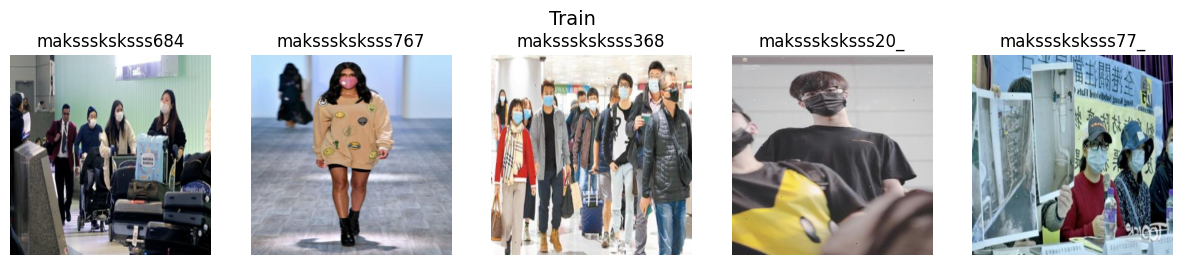

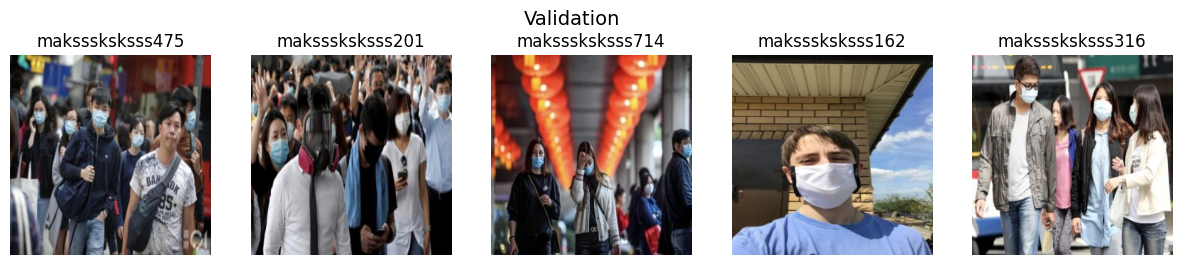

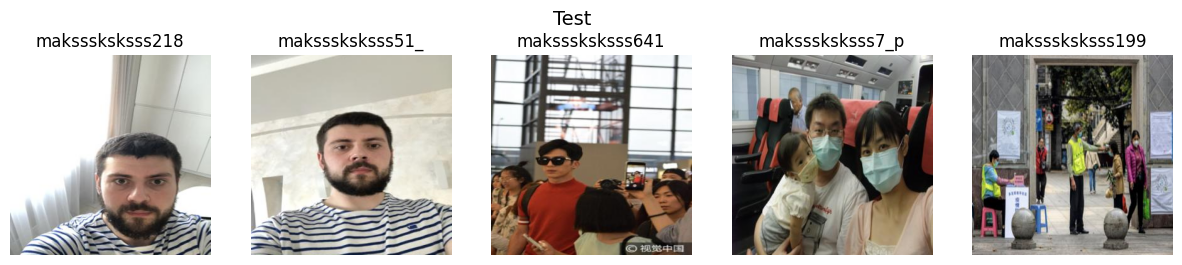

In [ ]:
# Preview datasets
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

BASE_DIR = "./face-mask-detection-1"

splits = [
    ("Train", os.path.join(BASE_DIR, "train/images")),
    ("Validation", os.path.join(BASE_DIR, "valid/images")),
    ("Test", os.path.join(BASE_DIR, "test/images")),
]

for split_name, image_dir in splits:
    images = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    samples = random.sample(images, min(5, len(images)))

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(img_name[:15])

    plt.suptitle(split_name, fontsize=14)
    plt.show()


Datasets training distribution

In [ ]:
import os

BASE_DIR = "./face-mask-detection-1"

train_count = len([f for f in os.listdir(f"{BASE_DIR}/train/images") if f.lower().endswith((".jpg", ".png", ".jpeg"))])
val_count   = len([f for f in os.listdir(f"{BASE_DIR}/valid/images") if f.lower().endswith((".jpg", ".png", ".jpeg"))])
test_count  = len([f for f in os.listdir(f"{BASE_DIR}/test/images") if f.lower().endswith((".jpg", ".png", ".jpeg"))])

print("Train:", train_count)
print("Val  :", val_count)
print("Test :", test_count)


Train: 1776
Val  : 171
Test : 85


## Training script

The YOLOv26 medium (m) model was used in this experiment. The model was trained with a 320 × 320 pixel input size to support low-resource mobile edge devices, using the default learning rate for up to 100 epochs with early stopping at 30 epochs. Training was conducted using a single class label: *face*.


In [ ]:
!yolo train model=yolo26m.pt data="./face-mask-detection-1/data.yaml" epochs=100 patience=30 imgsz=320 plots=True

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./face-mask-detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspect

In [ ]:
!ls ./runs/detect/train/weights


best.pt  last.pt


In [ ]:
!cp ./runs/detect/train/weights/best.pt ./face.pt


## Validation

In [ ]:
!yolo task=detect mode=val model="./face.pt" data="./face-mask-detection-1/data.yaml" split=test

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m summary (fused): 132 layers, 20,350,223 parameters, 0 gradients, 67.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 47.5±80.4 MB/s, size: 18.7 KB)
val: Scanning /content/face_masknomask_datasets/face-mask-detection-1/test/labels... 85 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 85/85 1.0Kit/s 0.1s
val: New cache created: /content/face_masknomask_datasets/face-mask-detection-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 3.3it/s 1.8s
                   all         85        373      0.947       0.91      0.962      0.662
Speed: 1.1ms preprocess, 10.3ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/face_masknomask_datasets/runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!yolo task=detect mode=val model="./face.pt" data="./face-mask-detection-1/data.yaml" split=val

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m summary (fused): 132 layers, 20,350,223 parameters, 0 gradients, 67.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 696.4±319.4 MB/s, size: 13.8 KB)
val: Scanning /content/face_masknomask_datasets/face-mask-detection-1/valid/labels.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 31.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 3.6it/s 3.1s
                   all        171        874      0.944      0.847      0.922      0.641
Speed: 1.3ms preprocess, 7.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /content/face_masknomask_datasets/runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


On the validation dataset, the model achieved high precision of 0.944 and a recall of 0.847, indicating reliable detections with a low false positive rate. The mAP50 score of 0.922 demonstrates strong detection performance, while the mAP50–95 score of 0.641 reflects reasonable localization accuracy under stricter evaluation criteria.

On the test dataset, the model showed improved performance with a precision of 0.947 and a recall of 0.910. The mAP@0.5 increased to 0.962, and the mAP50–95  reached 0.662, suggesting better generalization and more precise bounding box localization on unseen data.

In case for this result especially the case of strict condition, the low into medium threshold confidence can be applied to the model.


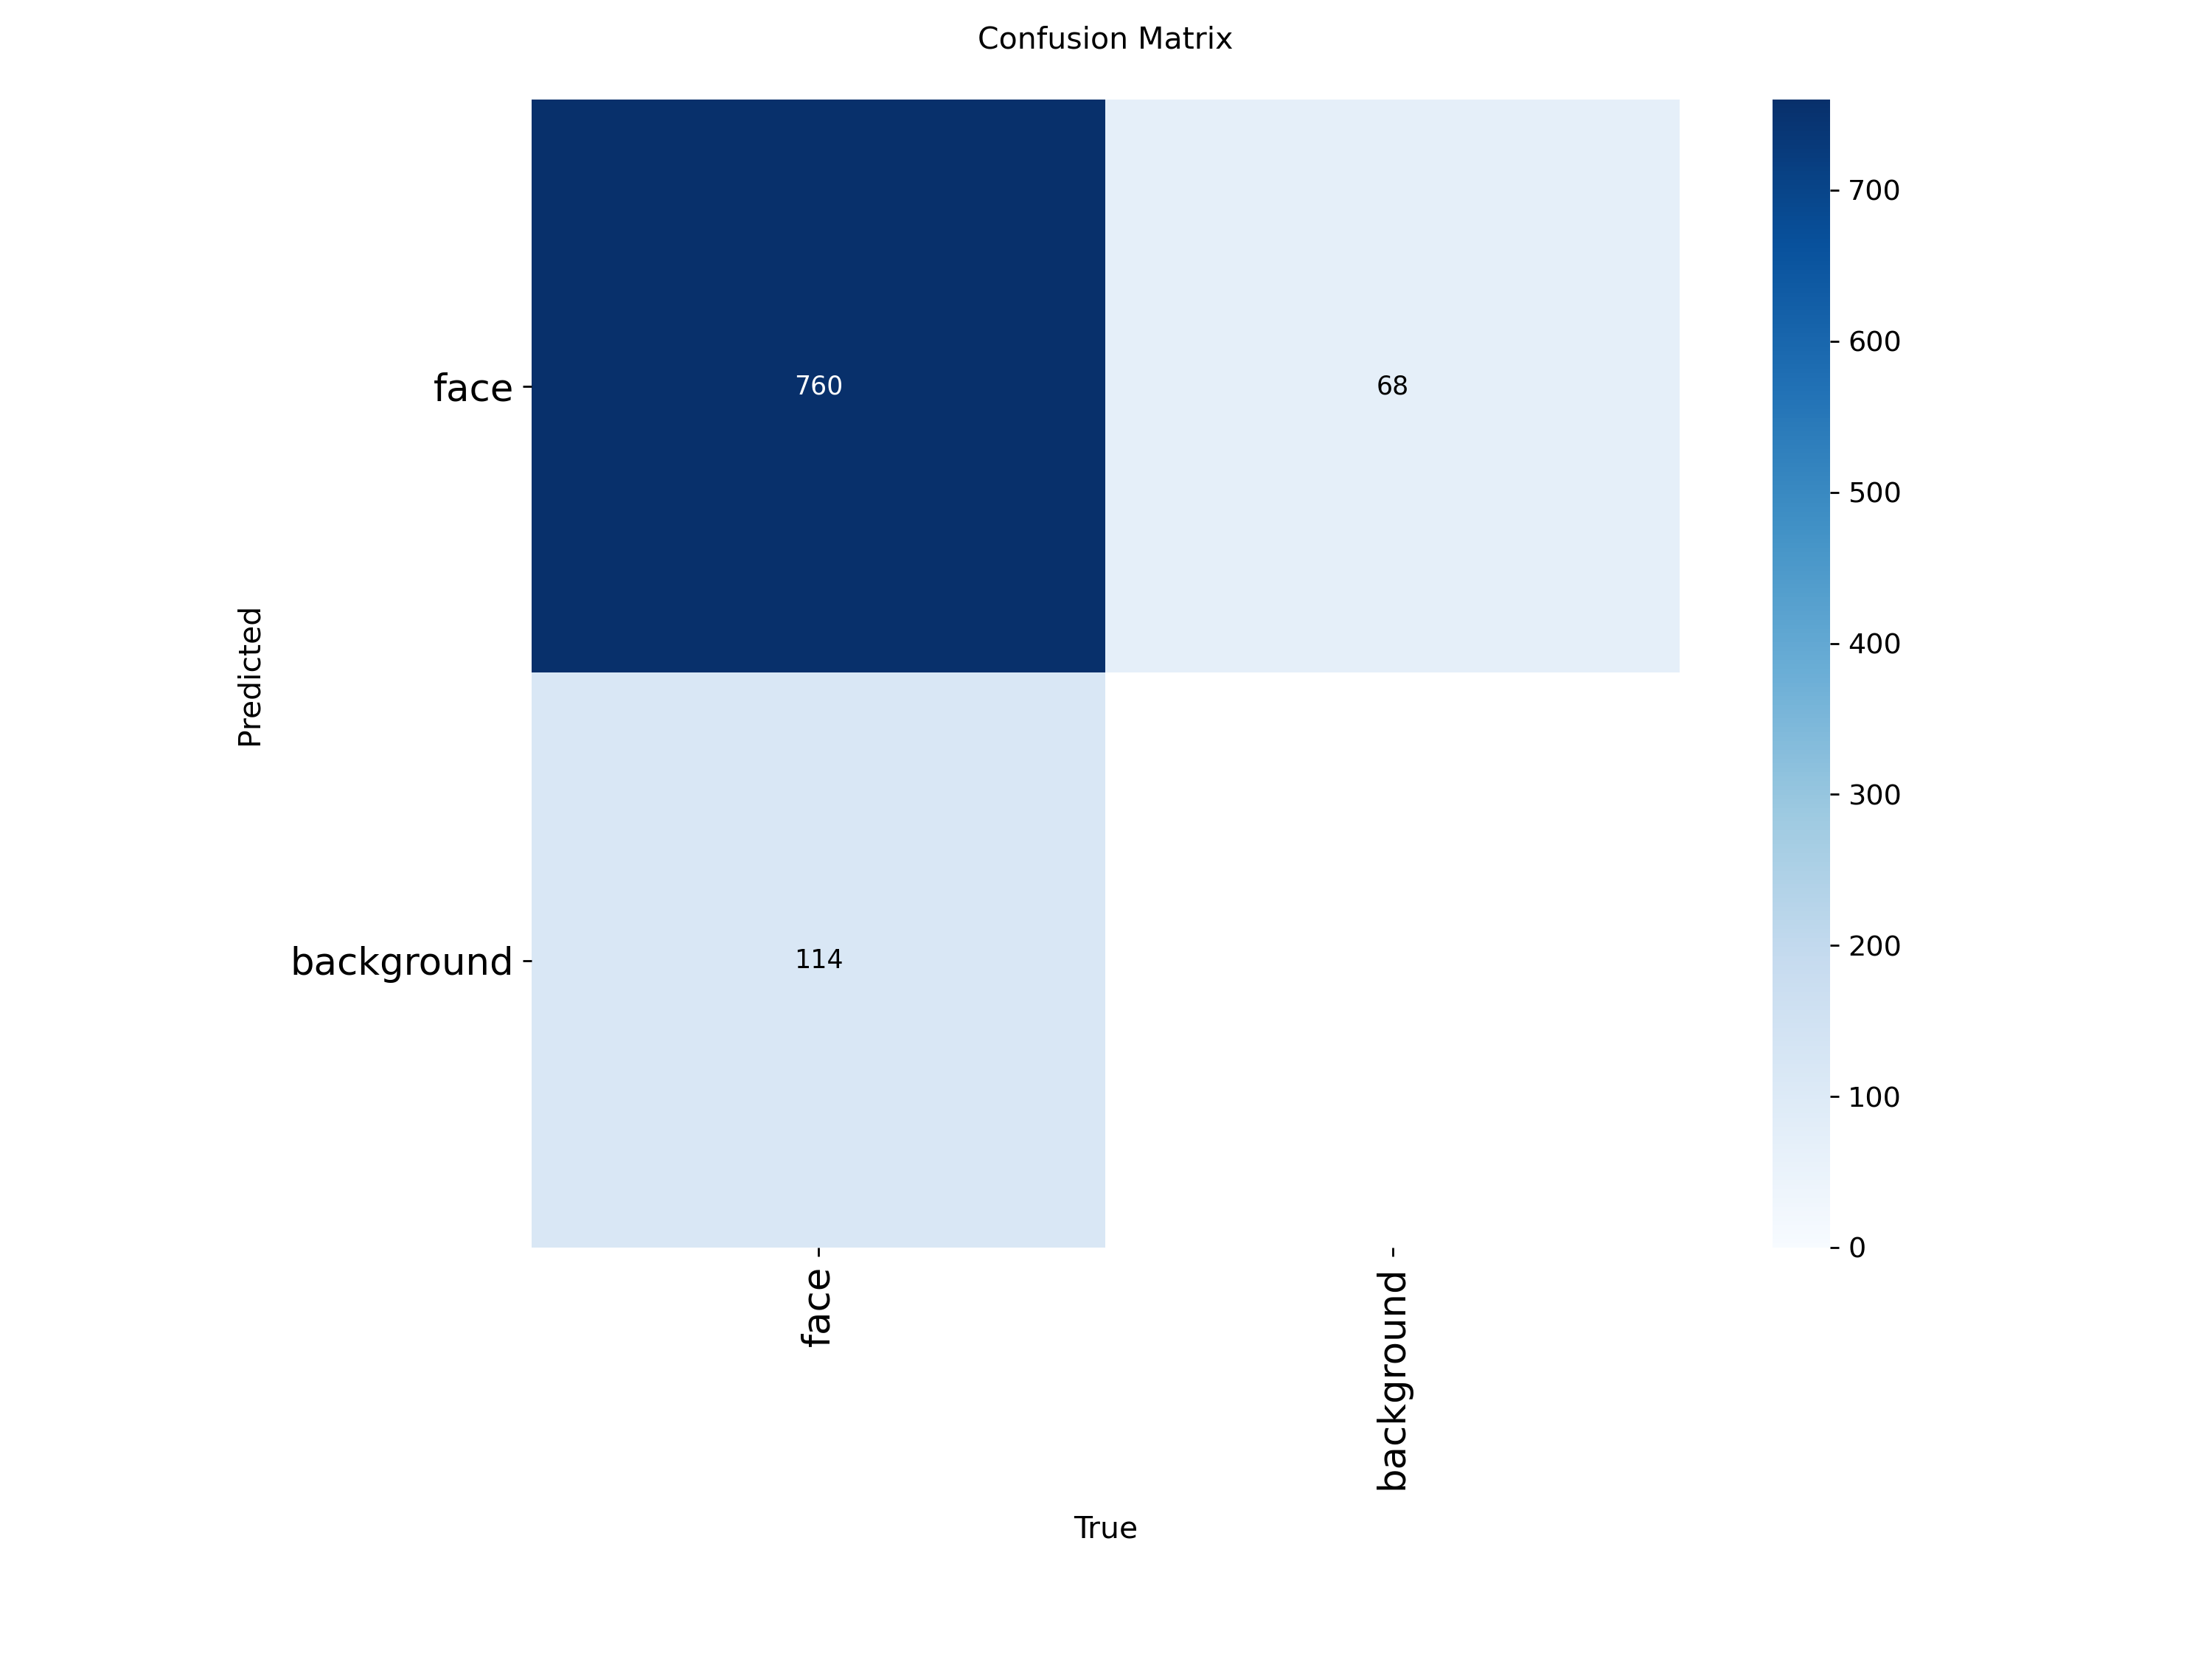

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'./runs/detect/train/confusion_matrix.png', width=600)

The confusion matrix above indicates that, using the default confidence threshold of 0.7, the model achieves more than 80% true positive detections. However, approximately 12% of the predictions correspond to false positives, where background regions are misclassified as faces. In addition, around 8% of face instances in the ground truth are not detected by the model, resulting in false negatives.

This behavior is likely affected by image quality. When faces appear far from the camera or at a small scale, the predicted confidence scores tend to be low, or the detections may be missed entirely.


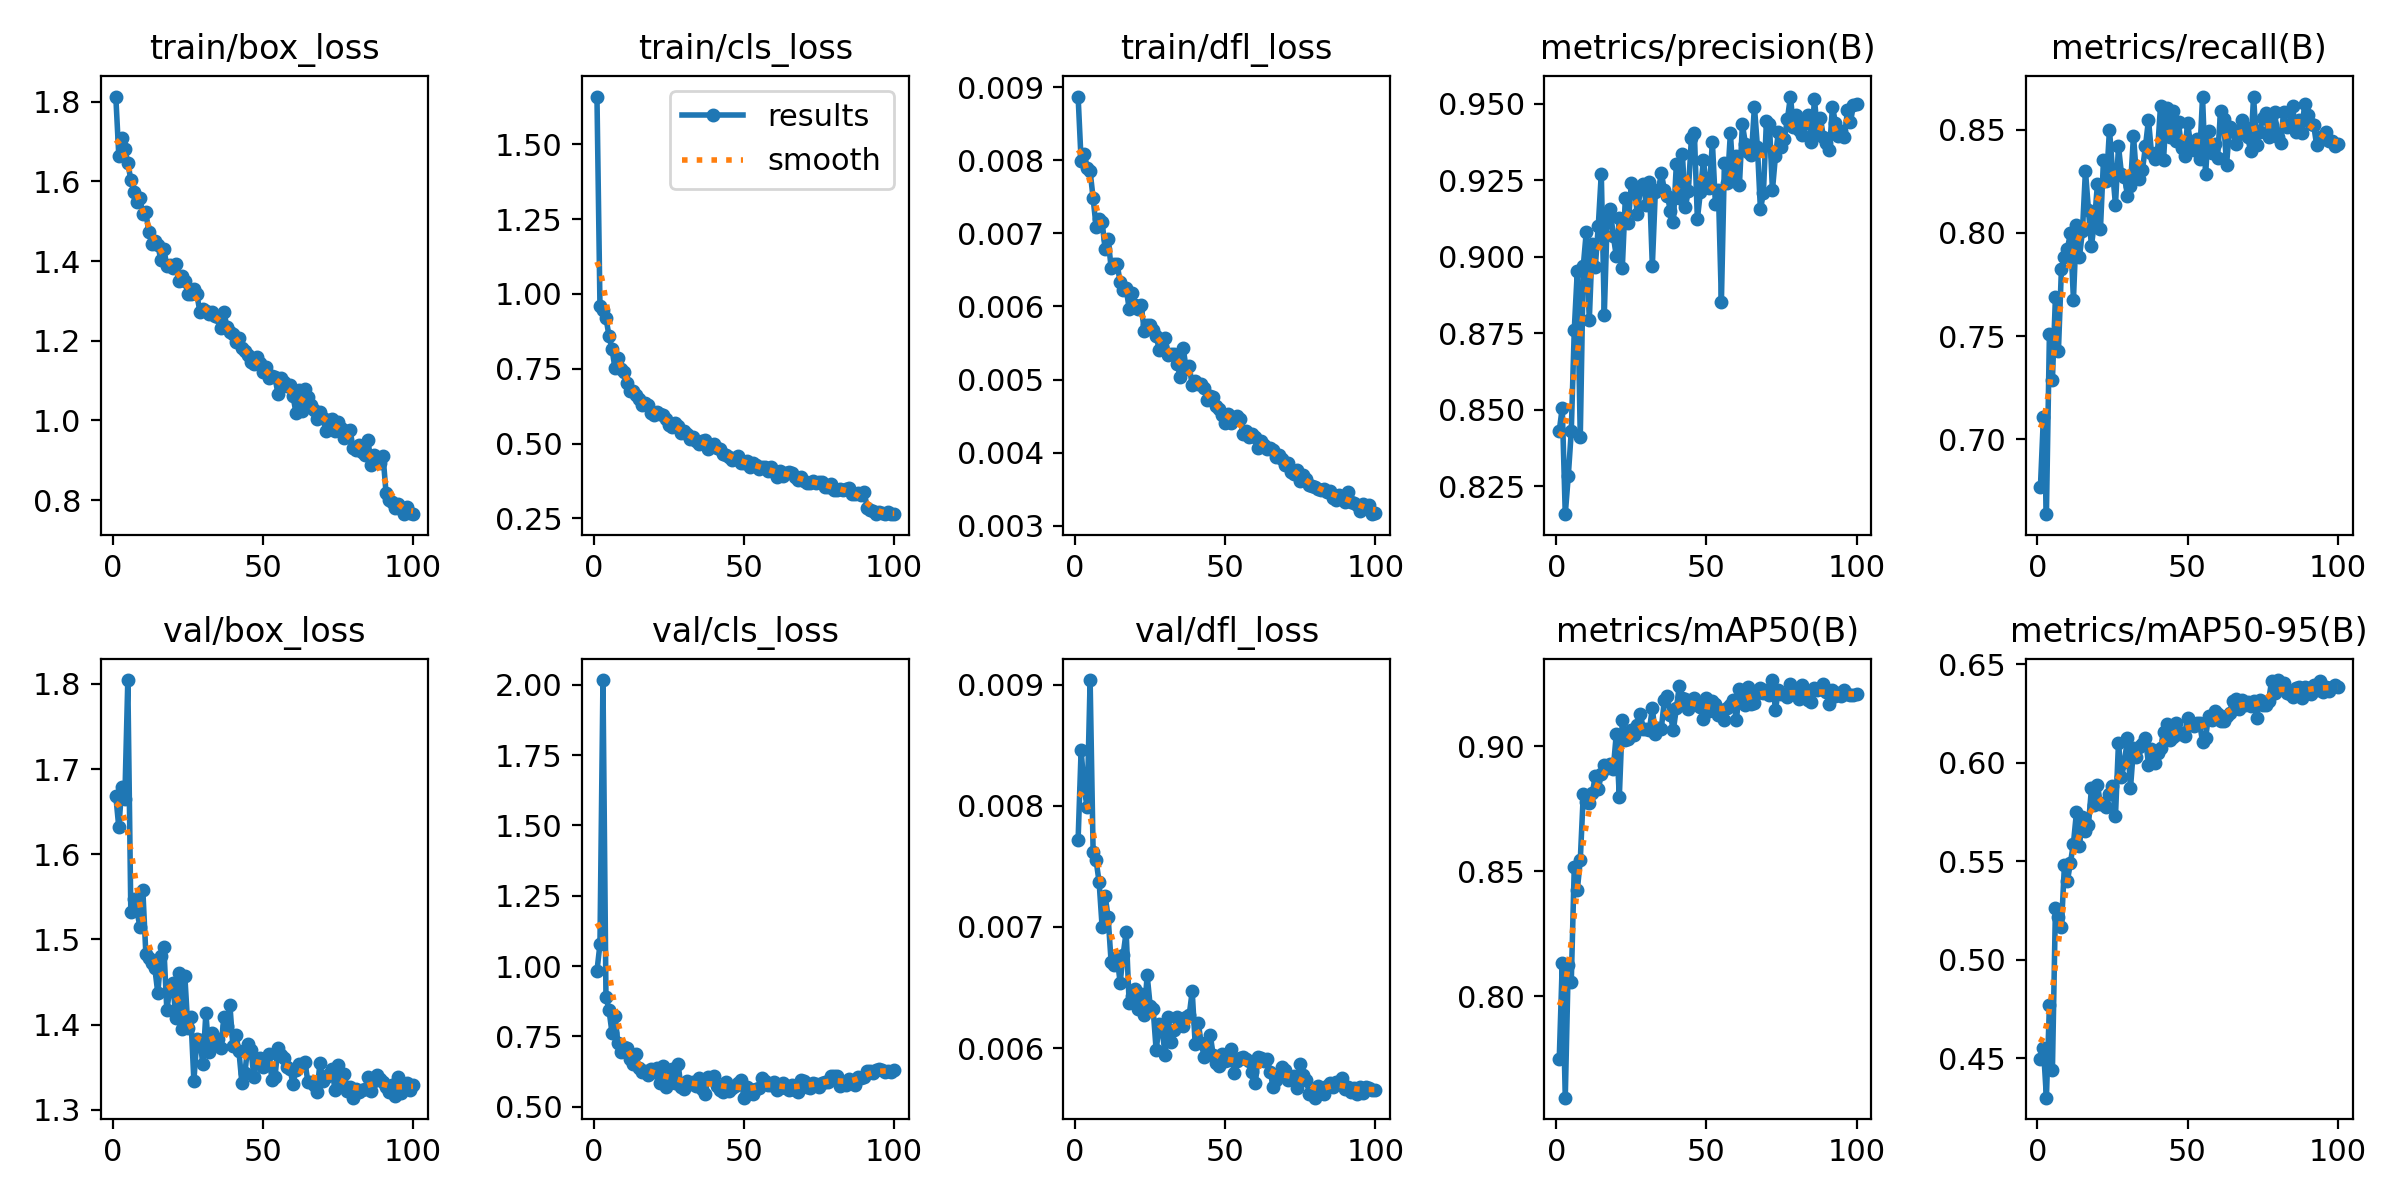

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'./runs/detect/train/results.png', width=600)

The training progress plot above shows that the model’s accuracy consistently increases throughout the training process. Although the strict evaluation metric (mAP50–95) indicates that model performance has not yet optimal, both training and validation losses steadily decrease. This trend is consistent with the observed improvements in overall accuracy, reflecting meaningful performance gains during training.


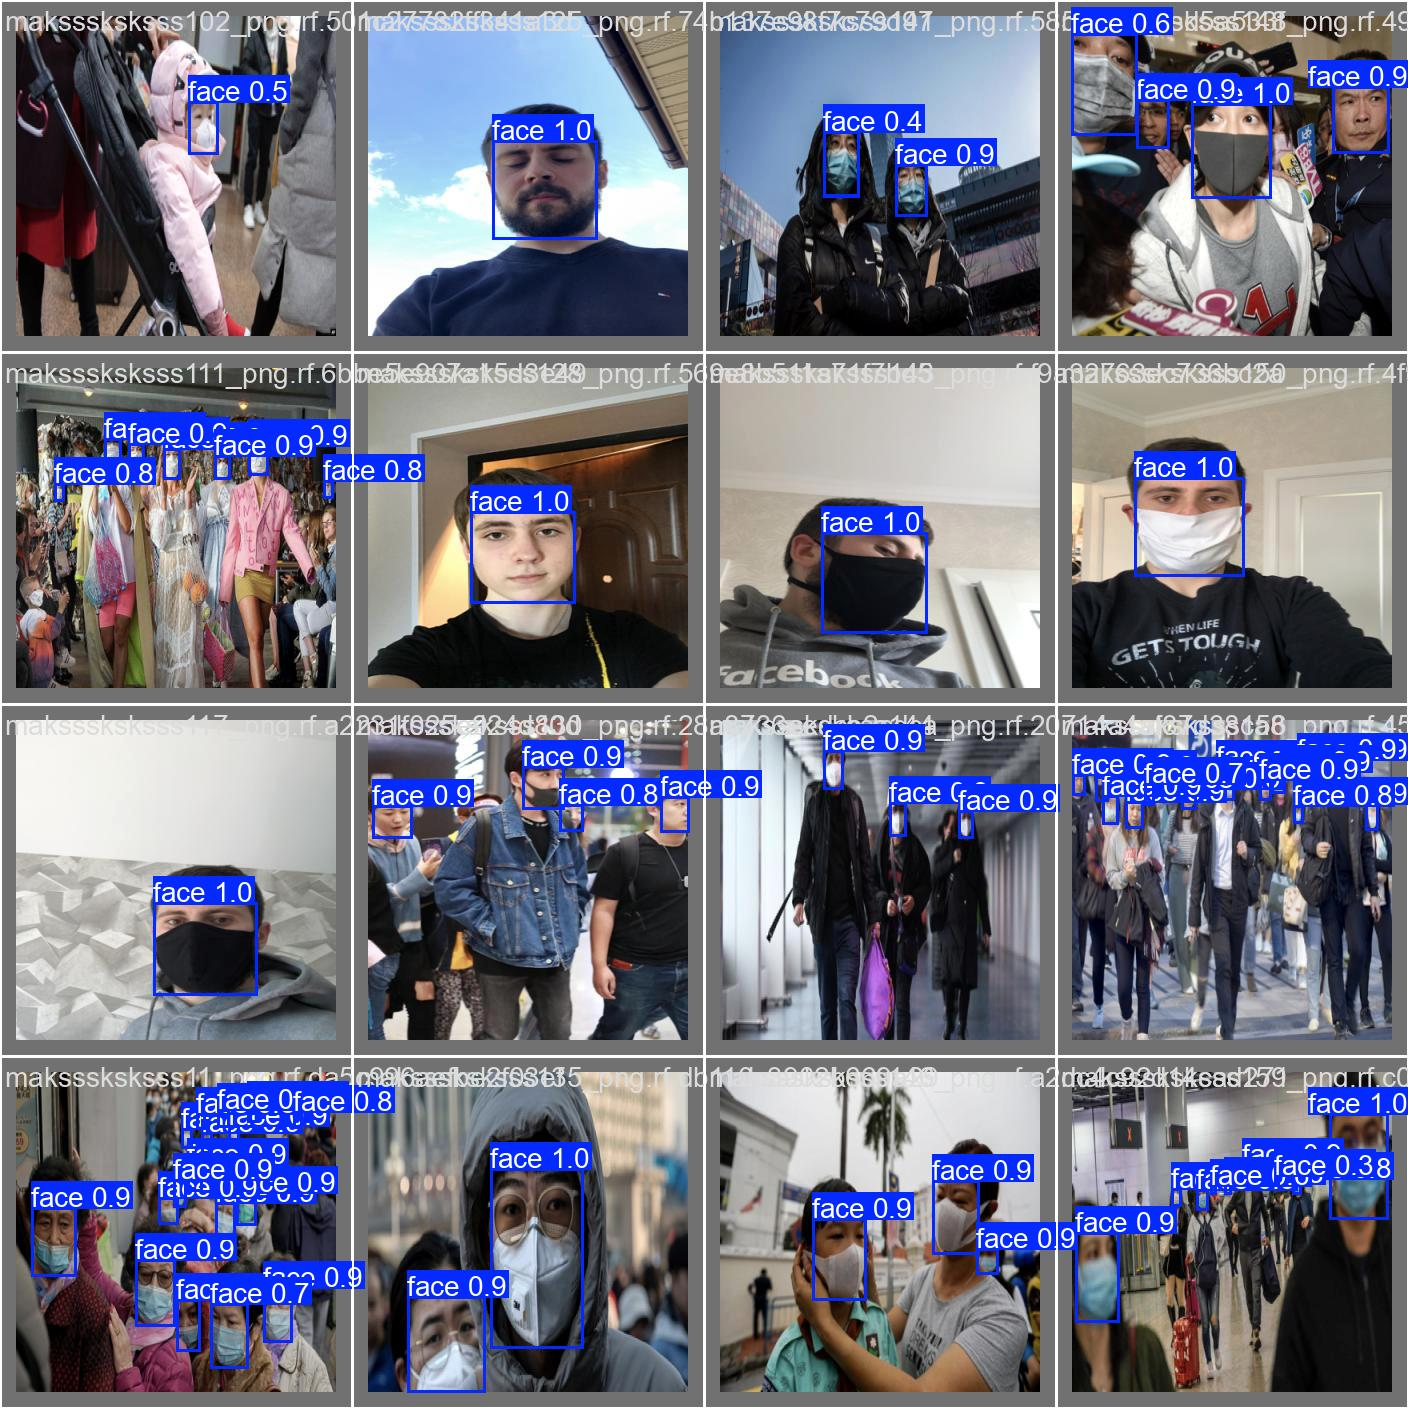

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename='./runs/detect/train/val_batch0_pred.jpg', width=600)

The images above illustrate the bounding box predictions produced by the model, along with variations in confidence scores. These results support the argument that differences in viewing angles and image quality can significantly affect model predictions. They also reflect effect of distribution of the dataset, including variations in mask usage, incorrect mask placement, facial angles, and the spatial position of individuals within the image.


In [ ]:
!yolo task=detect mode=predict model="./face.pt" conf=0.7 source={dataset.location}/test/images save=True

Ultralytics 8.4.11 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO26m summary (fused): 132 layers, 20,350,223 parameters, 0 gradients, 67.8 GFLOPs

image 1/85 /content/face_masknomask_datasets/face-mask-detection-1/test/images/maksssksksss104_png.rf.9d0a73bcf6e57f0981f3a95dbca289e8.jpg: 320x320 6 faces, 16.0ms
image 2/85 /content/face_masknomask_datasets/face-mask-detection-1/test/images/maksssksksss108_png.rf.0a9ed909b5a1ebada73e1b457367b65e.jpg: 320x320 3 faces, 15.9ms
image 3/85 /content/face_masknomask_datasets/face-mask-detection-1/test/images/maksssksksss131_png.rf.5a80bc71e921cdeac652e0123c0a0054.jpg: 320x320 6 faces, 15.8ms
image 4/85 /content/face_masknomask_datasets/face-mask-detection-1/test/images/maksssksksss134_png.rf.9d4812ee0eb95e12314103b35367d9db.jpg: 320x320 5 faces, 15.8ms
image 5/85 /content/face_masknomask_datasets/face-mask-detection-1/test/images/maksssksksss137_png.rf.5102354aa4fe6654a3c852b08c416672.jpg: 320x320 6 faces, 15.8ms
image 6/85 /